# Econometric Methods in R
### by [Jason DeBacker](http://jasondebacker.com), October 2019

This notebook illustrates some of the econometric tools available in R by estimating OLS, IV models.

To illustrate OLS and IV estimators, we'll use some example data from an econometic textbook.  To get these data, we'll install the `AER` package in R.  This package contains functions, data sets, examples, demos, and vignettes for the book Christian Kleiber and Achim Zeileis (2008).

In [1]:
# install package (if not done already)
install.packages('AER')
# import package
library(AER)


The downloaded binary packages are in
	/var/folders/b0/wwxd0byd1hx0y_rqrnqhmc0m0000gn/T//Rtmp5HYwhb/downloaded_packages


Loading required package: car
Loading required package: carData
Loading required package: lmtest
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: survival


 # OLS and IV

We'll look at the implementation of OLS and IV estimators by estimating models of female labor supply.  We'll do this with data on married women from the 1976 PSID.  This example comes from [this](https://www.r-bloggers.com/instrumental-variables-in-r-exercises-part-3/) exercise from R-bloggers.

In [2]:
## Load data from the 1976 PSID and look at first 5 rows
data("PSID1976")
PSID1976[1:5,]  # print the first 5 rows
summary(PSID1976)

participation,hours,youngkids,oldkids,age,education,wage,repwage,hhours,hage,⋯,hwage,fincome,tax,meducation,feducation,unemp,city,experience,college,hcollege
<fct>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<fct>,<int>,<fct>,<fct>
yes,1610,1,0,32,12,3.3540,2.65,2708,34,⋯,4.0288,16310,0.7215,12,7,5.0,no,14,no,no
yes,1656,0,2,30,12,1.3889,2.65,2310,30,⋯,8.4416,21800,0.6615,7,7,11.0,yes,5,no,no
yes,1980,1,3,35,12,4.5455,4.04,3072,40,⋯,3.5807,21040,0.6915,12,7,5.0,no,15,no,no
yes,456,0,3,34,12,1.0965,3.25,1920,53,⋯,3.5417,7300,0.7815,7,7,5.0,no,6,no,no
yes,1568,1,2,31,14,4.5918,3.60,2000,32,⋯,10.0000,27300,0.6215,12,14,9.5,yes,7,yes,no


 participation     hours          youngkids         oldkids     
 no :325       Min.   :   0.0   Min.   :0.0000   Min.   :0.000  
 yes:428       1st Qu.:   0.0   1st Qu.:0.0000   1st Qu.:0.000  
               Median : 288.0   Median :0.0000   Median :1.000  
               Mean   : 740.6   Mean   :0.2377   Mean   :1.353  
               3rd Qu.:1516.0   3rd Qu.:0.0000   3rd Qu.:2.000  
               Max.   :4950.0   Max.   :3.0000   Max.   :8.000  
      age          education          wage           repwage         hhours    
 Min.   :30.00   Min.   : 5.00   Min.   : 0.000   Min.   :0.00   Min.   : 175  
 1st Qu.:36.00   1st Qu.:12.00   1st Qu.: 0.000   1st Qu.:0.00   1st Qu.:1928  
 Median :43.00   Median :12.00   Median : 1.625   Median :0.00   Median :2164  
 Mean   :42.54   Mean   :12.29   Mean   : 2.375   Mean   :1.85   Mean   :2267  
 3rd Qu.:49.00   3rd Qu.:13.00   3rd Qu.: 3.788   3rd Qu.:3.58   3rd Qu.:2553  
 Max.   :60.00   Max.   :17.00   Max.   :25.000   Max.   :9.98   

In [3]:
# Get a list of all column names
str(PSID1976)

'data.frame':	753 obs. of  21 variables:
 $ participation: Factor w/ 2 levels "no","yes": 2 2 2 2 2 2 2 2 2 2 ...
 $ hours        : int  1610 1656 1980 456 1568 2032 1440 1020 1458 1600 ...
 $ youngkids    : int  1 0 1 0 1 0 0 0 0 0 ...
 $ oldkids      : int  0 2 3 3 2 0 2 0 2 2 ...
 $ age          : int  32 30 35 34 31 54 37 54 48 39 ...
 $ education    : int  12 12 12 12 14 12 16 12 12 12 ...
 $ wage         : num  3.35 1.39 4.55 1.1 4.59 ...
 $ repwage      : num  2.65 2.65 4.04 3.25 3.6 4.7 5.95 9.98 0 4.15 ...
 $ hhours       : int  2708 2310 3072 1920 2000 1040 2670 4120 1995 2100 ...
 $ hage         : int  34 30 40 53 32 57 37 53 52 43 ...
 $ heducation   : int  12 9 12 10 12 11 12 8 4 12 ...
 $ hwage        : num  4.03 8.44 3.58 3.54 10 ...
 $ fincome      : int  16310 21800 21040 7300 27300 19495 21152 18900 20405 20425 ...
 $ tax          : num  0.722 0.661 0.692 0.781 0.622 ...
 $ meducation   : int  12 7 12 7 12 14 14 3 7 7 ...
 $ feducation   : int  7 7 7 7 14 7 7 3 7 7 ..

We'll be looking at female labor supply of married women, so let's define a dataset that is just married women who are in the labor force.

In [4]:
# Subset data to just get those participating in the labor force
df <- subset(PSID1976, participation == "yes")

## OLS

We start with a simple OLS model estimating the impact of education and experience on log wages:

$$ ln(wage_{i}) = \alpha + \beta_{1} education_i + \beta_{2}experience_{i} + \beta_{3} experience^{2}_{i} + \varepsilon_i $$

To estimate an OLS model in R, use the [`lm()`](https://www.rdocumentation.org/packages/stats/versions/3.4.1/topics/lm) function.

In [7]:
# Define and estimate the model
wage_OLS <- lm(log(df[['wage']]) ~ df$education + df$experience + I(df$experience^2))
# wage_OLS
summary(wage_OLS)


Call:
lm(formula = log(df[["wage"]]) ~ df$education + df$experience + 
    I(df$experience^2))

Residuals:
     Min       1Q   Median       3Q      Max 
-3.08404 -0.30627  0.04952  0.37498  2.37115 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -0.5220406  0.1986321  -2.628  0.00890 ** 
df$education        0.1074896  0.0141465   7.598 1.94e-13 ***
df$experience       0.0415665  0.0131752   3.155  0.00172 ** 
I(df$experience^2) -0.0008112  0.0003932  -2.063  0.03974 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6664 on 424 degrees of freedom
Multiple R-squared:  0.1568,	Adjusted R-squared:  0.1509 
F-statistic: 26.29 on 3 and 424 DF,  p-value: 1.302e-15


If you wanted to adjust the standard errors (e.g., clutered, robust, etc), you will use the `coeftest()` function after your model is esitmate with a keyword arugment that allows you to set the variance-covariance matrix used for the standard errors.  With this, we'll call the robust VCV matrix function [`vcovHC`](https://www.rdocumentation.org/packages/plm/versions/1.6-5/topics/vcovHC).

We won't use robust standard errors for these exercises, but to illustrate how this is done, suppose that we want robust standard errors for the model above.

In [8]:
# Compute robust standard errors using the HC1 method (same as Stata with "robust" option)
coeftest(wage_OLS, vcov = vcovHC(wage_OLS, "HC1"))


t test of coefficients:

                      Estimate  Std. Error t value Pr(>|t|)    
(Intercept)        -0.52204056  0.20165046 -2.5888 0.009961 ** 
df$education        0.10748964  0.01321897  8.1315 4.72e-15 ***
df$experience       0.04156651  0.01527304  2.7216 0.006765 ** 
I(df$experience^2) -0.00081119  0.00042007 -1.9311 0.054139 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


We can also estimate the linear model via a GMM estimator.  We should ge the same coefficients, but the standard errors are computed differently.

In [9]:
# install GMM package if not already have
install.packages('gmm')
library(gmm)


The downloaded binary packages are in
	/var/folders/b0/wwxd0byd1hx0y_rqrnqhmc0m0000gn/T//Rtmp5HYwhb/downloaded_packages


In [10]:
wage_GMM <- gmm(log(df$wage) ~ df$education + df$experience + I(df$experience^2),
                x = cbind(df$education, df$experience, I(df$experience^2)))
summary(wage_GMM)


Call:
gmm(g = log(df$wage) ~ df$education + df$experience + I(df$experience^2), 
    x = cbind(df$education, df$experience, I(df$experience^2)))


Method:  twoStep 

Kernel:  Quadratic Spectral

Coefficients:
                    Estimate     Std. Error   t value      Pr(>|t|)   
(Intercept)         -5.2204e-01   2.0342e-01  -2.5663e+00   1.0279e-02
df$education         1.0749e-01   1.3689e-02   7.8525e+00   4.0781e-15
df$experience        4.1567e-02   1.4317e-02   2.9033e+00   3.6923e-03
I(df$experience^2)  -8.1119e-04   3.9241e-04  -2.0672e+00   3.8713e-02

J-Test: degrees of freedom is 0 
                J-test                P-value             
Test E(g)=0:    2.98455924400836e-24  *******             


# Instrumental Variables Regression Models


## IV via 2SLS

Of course estimates to the returns to education in the model above are likely biased since education and wages are likely correlated with other factors we aren't (or can't) control for such as cognitive and non-cognitive abilities that make one more productive in school and on the job.

To reduce the bias that results from this ommited variable, let's estimate an instrumental variables (IV) model.  Here, we'll argue that the education of the woman's father is correlated with her education level, but not her wages (conditional on her education and experience).  Thus father's education can help provide exogenous variation in education (conditional on father's education and other covariates).

One approach to IV models is to use the two-stage least squares (2SLS) estimator, where a model of the woman's eduation is estimated in a first stage:

$$ education_{i} = \gamma_{0} + \gamma_{1}father\_education_{i} + \gamma_{2}experience_{i} + \gamma_{3} experience^{2}_{i} + u_i $$

And then the predicted values of the the woman's education are used in the second stage to estimate the returns to education:


$$ ln(wage_{i}) = \alpha + \beta_{1} \hat{education}_i + \beta_{2}experience_{i} + \beta_{3} experience^{2}_{i} + \varepsilon_i $$

In this way, we ensure that the error term is uncorrelated with the covariates in the second stage.

To estimate this model via 2SLS, we'll use the [`iv_reg()`](https://www.rdocumentation.org/packages/AER/versions/1.2-5/topics/ivreg) function.

In [11]:
# Call the ivreg() function.  Note the "|" to separate the first stage equation
wage_IV <- ivreg(log(df$wage) ~ df$education + df$experience + I(df$experience^2) |
                 df$feducation + df$experience + I(df$experience^2))

summary(wage_IV)


Call:
ivreg(formula = log(df$wage) ~ df$education + df$experience + 
    I(df$experience^2) | df$feducation + df$experience + I(df$experience^2))

Residuals:
     Min       1Q   Median       3Q      Max 
-3.09170 -0.32776  0.05006  0.37365  2.35346 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)   
(Intercept)        -0.0611170  0.4364461  -0.140  0.88870   
df$education        0.0702263  0.0344427   2.039  0.04208 * 
df$experience       0.0436716  0.0134001   3.259  0.00121 **
I(df$experience^2) -0.0008822  0.0004009  -2.200  0.02832 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6719 on 424 degrees of freedom
Multiple R-Squared: 0.143,	Adjusted R-squared: 0.137 
Wald test: 8.314 on 3 and 424 DF,  p-value: 2.201e-05 


## Testing for endogeneity

A standard test to run for IV models is the Hausman test for edogeneity fo the suspected endogenous variable.  This is available in the diagnostics done in the `ivreg()` function.  To print this with the other output, add the `diagnostics = TRUE` to the keyword arguments in `summary()`:

In [12]:
summary(wage_IV, diagnostics = TRUE)


Call:
ivreg(formula = log(df$wage) ~ df$education + df$experience + 
    I(df$experience^2) | df$feducation + df$experience + I(df$experience^2))

Residuals:
     Min       1Q   Median       3Q      Max 
-3.09170 -0.32776  0.05006  0.37365  2.35346 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)   
(Intercept)        -0.0611170  0.4364461  -0.140  0.88870   
df$education        0.0702263  0.0344427   2.039  0.04208 * 
df$experience       0.0436716  0.0134001   3.259  0.00121 **
I(df$experience^2) -0.0008822  0.0004009  -2.200  0.02832 * 

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   1 424    87.741  <2e-16 ***
Wu-Hausman         1 423     1.437   0.231    
Sargan             0  NA        NA      NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6719 on 424 degrees of freedom
Multiple R-Squared: 0.143,	Adjusted R-squared: 0.137 
Wald test: 8.314 on 3 and 424 DF,  p-value

Here, we see that the Wu-Hausman test finds that we can't reject the null hypothesis that OLS is consistent - at least at standard levels of significance.

## IV via GMM

We can also estimate this instrumental variables model via GMM.  The GMM estimator has the following $K$ moment conditions (where $K$ are the number of instruments in $z_{i}$):

$$ g(\beta_{0}) = E[z_{i}\varepsilon_{i}] = E[z_{i}(y_{i}-x_{i}^{'}\beta_{0}] = 0 $$

Where $z_{i}$ is the instrument set (e.g., in the example here, $z_{i}$ = fathers's education, experience, and experience squared (and thus $K=4$).

To use this estimator, we'll call the `gmm()` function as we did above, this time specifying the instrument set.

In [13]:
z <- cbind(df$feducation, df$experience, I(df$experience^2))
wage_GMM_IV <- gmm(log(wage) ~ education + experience + I(experience^2),
              x = z, data = df)
summary(wage_GMM_IV)


Call:
gmm(g = log(wage) ~ education + experience + I(experience^2), 
    x = z, data = df)


Method:  twoStep 

Kernel:  Quadratic Spectral

Coefficients:
                 Estimate     Std. Error   t value      Pr(>|t|)   
(Intercept)      -0.06111695   0.47340884  -0.12909973   0.89727874
education         0.07022629   0.03786572   1.85461408   0.06365136
experience        0.04367159   0.01463274   2.98451114   0.00284032
I(experience^2)  -0.00088215   0.00040321  -2.18783174   0.02868186

J-Test: degrees of freedom is 0 
                J-test                P-value             
Test E(g)=0:    2.15174910016827e-24  *******             


As we'd expect, GMM returns the same point estimats, but different S.E.'s than 2SLS.

Now let's estimate an overidentified model.  When we do this, we can do some overidentification tests (e.g. to see that our excluded instruments are exogenous).  We have one potentially endogenous regressor, education.  If we add one more instrument, we will have an over-identified model.  Let's now use mother's education in addition to father's education in the set of excluded instruments.  And let's estimate this model via 2SLS.

In [14]:
# Call the ivreg() function.
wage_IV2 <- ivreg(log(df$wage) ~ df$education + df$experience + I(df$experience^2) |
                 df$feducation + df$meducation + df$experience + I(df$experience^2))

summary(wage_IV2, diagnostics=TRUE)


Call:
ivreg(formula = log(df$wage) ~ df$education + df$experience + 
    I(df$experience^2) | df$feducation + df$meducation + df$experience + 
    I(df$experience^2))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0986 -0.3196  0.0551  0.3689  2.3493 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)   
(Intercept)         0.0481003  0.4003281   0.120  0.90442   
df$education        0.0613966  0.0314367   1.953  0.05147 . 
df$experience       0.0441704  0.0134325   3.288  0.00109 **
I(df$experience^2) -0.0008990  0.0004017  -2.238  0.02574 * 

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   2 423    55.400  <2e-16 ***
Wu-Hausman         1 423     2.793  0.0954 .  
Sargan             1  NA     0.378  0.5386    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6747 on 424 degrees of freedom
Multiple R-Squared: 0.1357,	Adjusted R-squared: 0.1296 
Wald test: 8.141 on 3 and 424

The Sargan J-Stat has a p-value of 0.5386 meaning that we can't reject the null that the excluded instruments are exogenous (at least at standard levels of significance).

## Plotting lines of fit

Let's plot the line of best fit for the OLS model against the data to see how well the model predicts the data points.

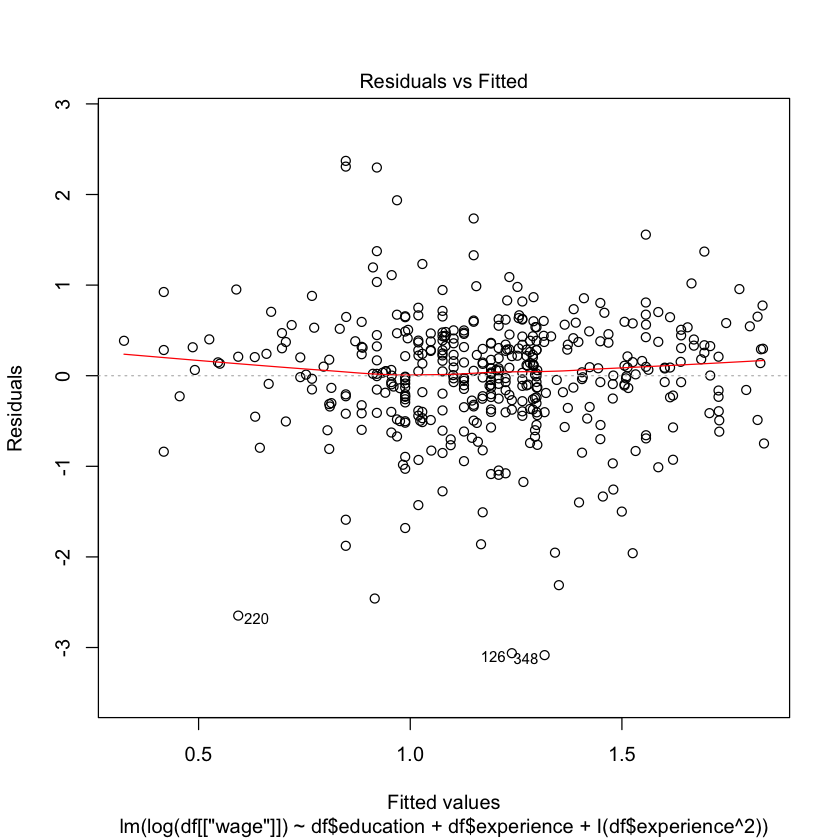

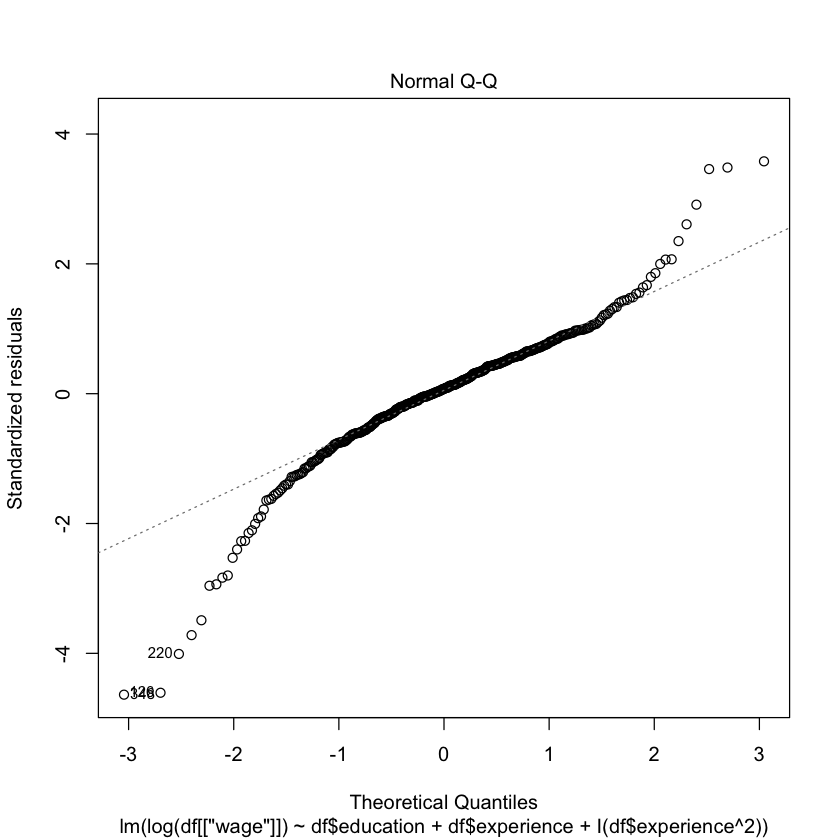

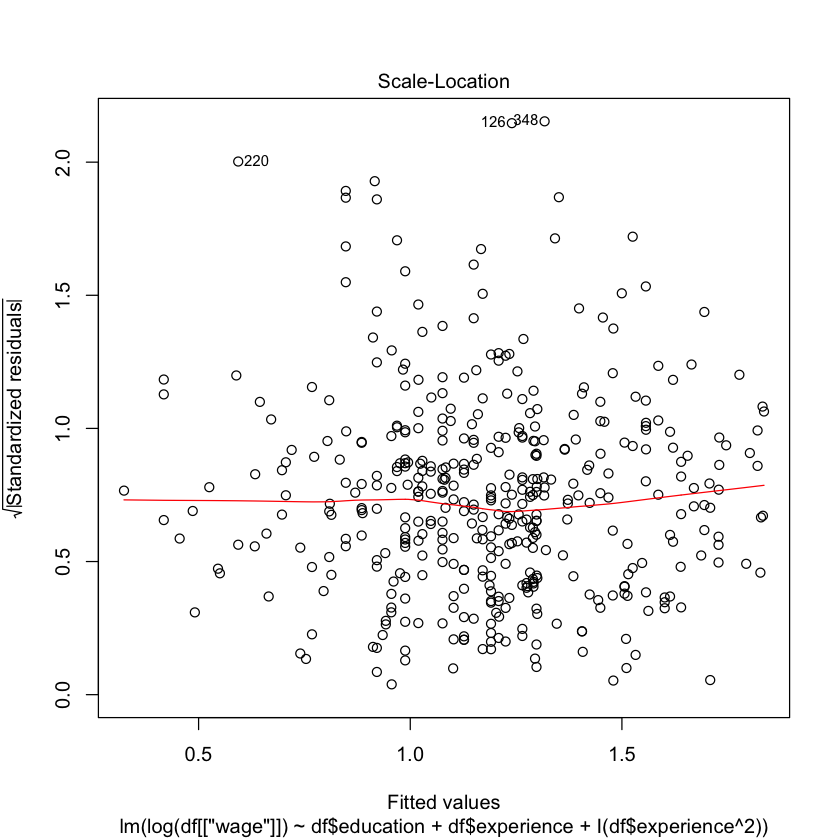

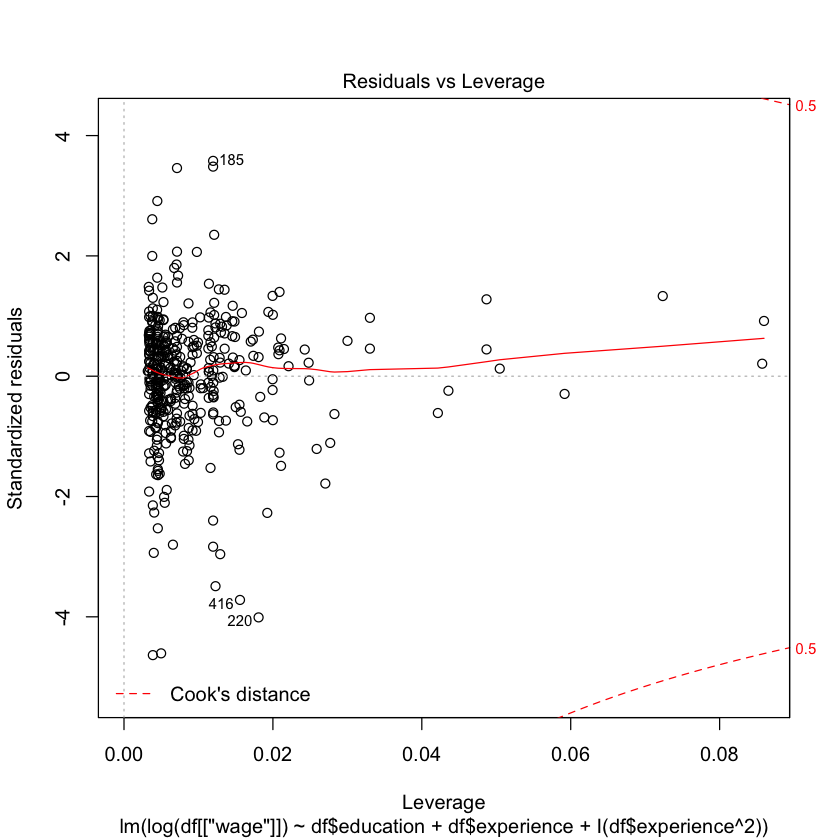

In [15]:
# The output of plot() depends on the object pass to it. In the cast of 
# the lm object, we see several plots of the fit
plot(wage_OLS)

## Printing regression output for external use

You will want to save model output you are interested in using in a paper/presentation into a format that can easily be put into nicely formated tables.  These tables may be in Excel or LaTeX or something else.  My preferred method has been to:
1. Save output from models into text files that are linked to in an Excel workbook
2. Have a worksheet in this workbook that reads the raw output from the models and another worksheet that formats the output for presentation (again, linking to the raw output worksheet so not manual manipulation needs to be done after this is initially set up).
3. I then use Excel2Latex to create the TeX code that reproduces this table.
4. The TeX code is pasted into my TeX document (usually requiring a few adjustments).

This may not be the most efficient method, but Excel gives a nice view of the results without having to compile TeX or scroll through a pdf) and there often needs to be some adjustment of variables names etc. to properly size tables and the intermediate step of using Excel can be helpful here.

In any case, I show how to output the model results as both TeX code and a text file (for importing into Excel) below.

## LaTeX tables from model results

A useful package for formatting all types of tabular objects from R into TeX is the [`xtable`](https://cran.r-project.org/web/packages/xtable/vignettes/xtableGallery.pdf) package. We'll use this to format our overidentified 2SLS model.

In [16]:
# install pacakge - if not already
install.packages('xtable')
# import package
library(xtable)


The downloaded binary packages are in
	/var/folders/b0/wwxd0byd1hx0y_rqrnqhmc0m0000gn/T//Rtmp5HYwhb/downloaded_packages


In [17]:
# make TeX table of wage_IV2 model
print(xtable(wage_OLS))

% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Tue Oct 15 13:45:46 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & Estimate & Std. Error & t value & Pr($>$$|$t$|$) \\ 
  \hline
(Intercept) & -0.5220 & 0.1986 & -2.63 & 0.0089 \\ 
  df\$education & 0.1075 & 0.0141 & 7.60 & 0.0000 \\ 
  df\$experience & 0.0416 & 0.0132 & 3.15 & 0.0017 \\ 
  I(df\$experience\verb|^|2) & -0.0008 & 0.0004 & -2.06 & 0.0397 \\ 
   \hline
\end{tabular}
\end{table}


But note that while simple, `xtable` doesn't support a number of classes.  E.g., it will not work with our `ivreg()` output (which is an object of the `ivreg` class as opposed to an the OLS output which are instances of the `lm` class.

A very flexible option is the [`texreg`](https://cran.r-project.org/web/packages/texreg/vignettes/texreg.pdf) package.  Let's use this package and the `texreg()` function to print out 2SLS and GMM IV models together in a table.

In [18]:
# install package - if not done so already
install.packages('texreg')
# import texreg library
library("texreg")


The downloaded binary packages are in
	/var/folders/b0/wwxd0byd1hx0y_rqrnqhmc0m0000gn/T//Rtmp5HYwhb/downloaded_packages


Version:  1.36.23
Date:     2017-03-03
Author:   Philip Leifeld (University of Glasgow)

Please cite the JSS article in your publications -- see citation("texreg").


In [19]:
# put models into a LaTeX table
print(texreg(list(wage_IV, wage_GMM), dcolumn = TRUE, booktabs = TRUE,
       use.packages = FALSE, label = "tab:3", caption = "Two IV models.",
       float.pos = "hb!"))
# To save to file have keyword argument `file="path/filename.txt"`


\begin{table}[hb!]
\begin{center}
\begin{tabular}{l D{.}{.}{3.4} D{.}{.}{3.5} }
\toprule
 & \multicolumn{1}{c}{Model 1} & \multicolumn{1}{c}{Model 2} \\
\midrule
(Intercept)        & -0.06     & -0.52^{*}  \\
                   & (0.44)    & (0.20)     \\
df$education       & 0.07^{*}  & 0.11^{***} \\
                   & (0.03)    & (0.01)     \\
df$experience      & 0.04^{**} & 0.04^{**}  \\
                   & (0.01)    & (0.01)     \\
I(df$experience^2) & -0.00^{*} & -0.00^{*}  \\
                   & (0.00)    & (0.00)     \\
\midrule
R$^2$              & 0.14      &            \\
Adj. R$^2$         & 0.14      &            \\
Num. obs.          & 428       &            \\
RMSE               & 0.67      &            \\
Criterion function &           & 0.00       \\
Num.\ obs.         &           & 428        \\
\bottomrule
\multicolumn{3}{l}{\scriptsize{$^{***}p<0.001$, $^{**}p<0.01$, $^*p<0.05$}}
\end{tabular}
\caption{Two IV models.}
\label{tab:3}
\end{center}
\end{table}


There are many formatting options and you can even rename the coefficients in the function call.  E.g.,

In [20]:
# put models into a LaTeX table
print(texreg(list(wage_IV, wage_GMM), dcolumn = TRUE, booktabs = TRUE,
       use.packages = FALSE, custom.model.names = c('2SLS', 'GMM'),
       custom.coef.names = c('Intercept', 'Education', 'Experience', '$Experience^{2}$'),
       label = "tab:3", caption = "Two IV models",
       float.pos = "hb!"))
# To save to file have keyword argument `file="path/filename.txt"`


\begin{table}[hb!]
\begin{center}
\begin{tabular}{l D{.}{.}{3.4} D{.}{.}{3.5} }
\toprule
 & \multicolumn{1}{c}{2SLS} & \multicolumn{1}{c}{GMM} \\
\midrule
Intercept          & -0.06     & -0.52^{*}  \\
                   & (0.44)    & (0.20)     \\
Education          & 0.07^{*}  & 0.11^{***} \\
                   & (0.03)    & (0.01)     \\
Experience         & 0.04^{**} & 0.04^{**}  \\
                   & (0.01)    & (0.01)     \\
$Experience^{2}$   & -0.00^{*} & -0.00^{*}  \\
                   & (0.00)    & (0.00)     \\
\midrule
R$^2$              & 0.14      &            \\
Adj. R$^2$         & 0.14      &            \\
Num. obs.          & 428       &            \\
RMSE               & 0.67      &            \\
Criterion function &           & 0.00       \\
Num.\ obs.         &           & 428        \\
\bottomrule
\multicolumn{3}{l}{\scriptsize{$^{***}p<0.001$, $^{**}p<0.01$, $^*p<0.05$}}
\end{tabular}
\caption{Two IV models}
\label{tab:3}
\end{center}
\end{table}


### Model output to text files

Another useful package for formatting output is [`stargazer`](https://cran.r-project.org/web/packages/stargazer/vignettes/stargazer.pdf).  As with `xtable` and `texreg` above, this can produce TeX tables, but it can also produce ASCII files that can be read into Excel (or other programs).  It is a very flexible package.  

In [21]:
# Install package if not already installed
install.packages('stargazer')
# Import package
library(stargazer)


The downloaded binary packages are in
	/var/folders/b0/wwxd0byd1hx0y_rqrnqhmc0m0000gn/T//Rtmp5HYwhb/downloaded_packages



Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [25]:
# Use stargazer to produce ascii output
# type="text" sets to ascii (default is LaTeX)
print(stargazer(wage_IV, wage_GMM, title="2 IV Models",
      align=TRUE, type="text", column.labels=c("2SLS","GMM"),
      dep.var.caption="", dep.var.labels="", dep.var.labels.include=FALSE,
      covariate.labels=c('Intercept', 'Education', 'Experience', '$Experience^{2}$'),
      no.space=TRUE))
# to save to file just have keyworkd argument `out="path.filename.txt"`


2 IV Models
                       instrumental       GMM   
                         variable               
                           2SLS           GMM   
                           (1)            (2)   
------------------------------------------------
Intercept                0.070**       0.107*** 
                         (0.034)        (0.014) 
Education                0.044***      0.042*** 
                         (0.013)        (0.014) 
Experience               -0.001**      -0.001** 
                         (0.0004)      (0.0004) 
Experience2               -0.061       -0.522** 
                         (0.436)        (0.203) 
------------------------------------------------
Observations               428            428   
R2                        0.143                 
Adjusted R2               0.137                 
Residual Std. Error  0.672 (df = 424)           
Note:                *p<0.1; **p<0.05; ***p<0.01
 [1] ""                                                


# References
Christian Kleiber and Achim Zeileis (2008), *Applied Econometrics with R*, Springer-Verlag, New York.
ISBN 978-0-387-77316-2.